In [1]:
%matplotlib inline
import os
import random
import itertools
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 14})

In [2]:
nlayers = 9


layer_index = range(1, nlayers + 1)

column_model = pd.Series(np.random.random(nlayers), index = layer_index)

In [44]:
# mcica

def get_mcica_column_modified_drawn(model = None, drawn = None):
    modified = pd.Series(np.zeros(model.shape), index = model.index)
    for l in model.index[1 :]:
        clearskyabove_model = 1 - model[l - 1]
        cloudskyabove_drawn = drawn[l - 1]
        
        if cloudskyabove_drawn > clearskyabove_model:
            modified[l] = cloudskyabove_drawn
        else:
            modified[l] = drawn[l] * clearskyabove_model
    modified.index = model.index
    return modified


def get_mcica_column_sub(model = None, modified = None):
    sub = pd.Series(np.ones(model.shape), index = model.index)
    return sub.where(modified > model, other = 0)


def get_mcica_columns_history(model = None, drawn = None, 
                              modified = None, sub = None):
    columns_list = [('model cloudsky', model),
                    ('model clearsky', 1 - model),
                    ('drawn', drawn),
                    ('drawn modified', modified),
                    ('sub column', sub)]

    history = pd.DataFrame.from_items(columns_list)
    history.iloc[:, : -1] = np.round(history.iloc[:, : -1], decimals = 2)
    return history


def plot_fracs(history = None):
    names_cloudsky = ('model cloudsky', 'drawn', 'drawn modified', 'sub column')
    
    fig, axs = plt.subplots(figsize = (len(names_cloudsky) * 3, 7), 
                            nrows = 1, ncols = len(names_cloudsky),
                            sharey = True)
    
    for ax, name in zip(axs, names_cloudsky):
        color = 'k' if name == 'sub column' else 'b'
        history[name].plot(ax = ax, kind = 'barh', width = .95, alpha = .3, color = color)
        ax.set_xlim((0, 1))
        ax.set_title(name)
        ax.invert_yaxis()
    
    plt.figtext(x = .07, y = .5, s = 'layer index', rotation = 90.)
    plt.figtext(x = .5, y = .05, s = 'cloud fraction', fontsize = 15)

#ax.set_ylabel('layer index')
        
#    plt.xlabel('cloud fraction [1]')
#    plt.ylabel('layer index')

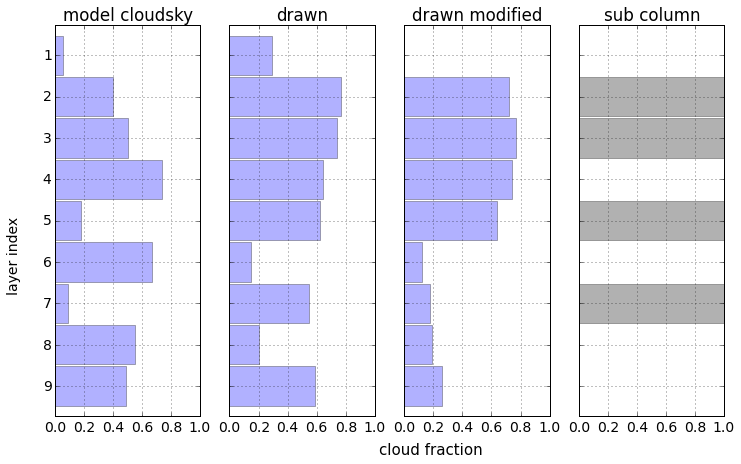

In [45]:
column_drawn = pd.Series(np.random.random(nlayers), index = layer_index)

column_modified = get_mcica_column_modified_drawn(model = column_model, drawn = column_drawn)

column_sub = get_mcica_column_sub(model = column_model, modified = column_modified)



columns_history = get_mcica_columns_history(model = column_model, 
                                            drawn = column_drawn,
                                            modified = column_modified,
                                            sub = column_sub)


plot_fracs(history = columns_history)


In [40]:
# MaxRand

def maxrand_maxcovers(model = None):
    nlayers_sec = int(len(model.index) / 3)
    maxcover_top = model.iloc[: nlayers_sec].max()
    maxcover_mid = model.iloc[nlayers_sec: 2 * nlayers_sec].max()
    maxcover_bot = model.iloc[2 * nlayers_sec: ].max()
    return pd.Series([maxcover_top, maxcover_mid, maxcover_bot], 
                     index = ['top', 'middle', 'bottom'])


def maxrand_maxcol(model = None):
    nlayers_sec = int(len(model.index) / 3)
    maxcovers = maxrand_maxcovers(model = model)
    maxcol = pd.Series(np.zeros(model.shape), index = model.index)
    maxcol.iloc[: nlayers_sec] = maxcovers['top']
    maxcol.iloc[nlayers_sec: 2 * nlayers_sec] = maxcovers['middle']
    maxcol.iloc[2 * nlayers_sec:] = maxcovers['bottom']
    return maxcol


def maxrand_subcol(nlayers = 9, top_cloudy = 0, mid_cloudy = 0, bot_cloudy = 0):
    subcol = pd.Series(np.zeros(nlayers), index = range(1, nlayers + 1))
    nlayer_sec = int(nlayers / 3)
    subcol.iloc[: nlayer_sec] = 1 if top_cloudy else 0
    subcol.iloc[nlayer_sec: 2 * nlayer_sec] = 1 if mid_cloudy else 0
    subcol.iloc[2 * nlayer_sec: ] = 1 if bot_cloudy else 0
    return subcol


def maxrand_subcol_prob(model = None, top_cloudy = 0, mid_cloudy = 0, bot_cloudy = 0):
    cloudy = maxrand_maxcovers(model)
    clearsky = 1 - cloudy
    df = pd.DataFrame({1: cloudy, 0: clearsky})
    probability = df.loc['top', top_cloudy] * \
    df.loc['middle', mid_cloudy] * \
    df.loc['bottom', bot_cloudy]
    return probability


def maxrand_plot_subcol_prob(model = None):
    subcol_cloudys = itertools.product([1, 0], repeat = 3)
    d_subcol_cloudys = [dict(zip(['top_cloudy', 'mid_cloudy', 'bot_cloudy'],
                               subcol_cloudy)) for subcol_cloudy in subcol_cloudys] 
    
    nlayers = len(model.index)
    
    fig, axs = plt.subplots(figsize = (3 * 8, 6),
                           nrows = 1, ncols = 8,
                           sharey = True)
    
    for ax, d in zip(axs, d_subcol_cloudys):
        subcol = maxrand_subcol(nlayers = nlayers, **d)
        prob_subcol = maxrand_subcol_prob(model=model, **d)
        subcol.plot(ax = ax, kind = 'barh', alpha = .3, color = 'k', width = .95)
        ax.set_title('prob = {:.2f}'.format(prob_subcol))
        ax.set_xlim((0, 1))
        
        ax.invert_yaxis()
        
    plt.figtext(x = 0.1, y = .5, s = 'layer index', rotation = 90.)    
    plt.figtext(x = .5, y = .05, s = 'cloud fraction')
    return fig


def maxrand_plot_maxcol(model = None):
    maxcol = maxrand_maxcol(model = model)
    fig, axs = plt.subplots(figsize = (3 * 2, 6),
                           ncols = 2, nrows = 1,
                           sharey = True)
    for ax, col , name in zip(axs, [model, maxcol], ['model', 'max overlapped']):
        col.plot(ax = ax, kind = 'barh', width = .95, alpha = .3, color = 'b')
        ax.set_xlim((0, 1))
        ax.set_title(name)
    
    plt.figtext(x = 0.05, y = .5, s = 'layer index', rotation = 90.)
    plt.figtext(x = .5, y = .05, s = 'cloud fraction')
    return fig

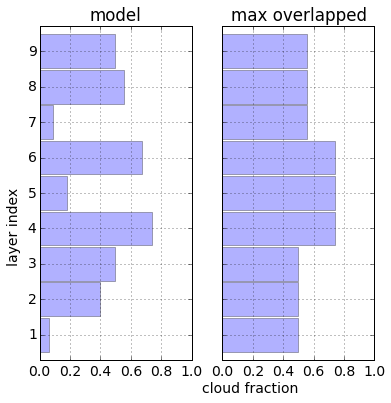

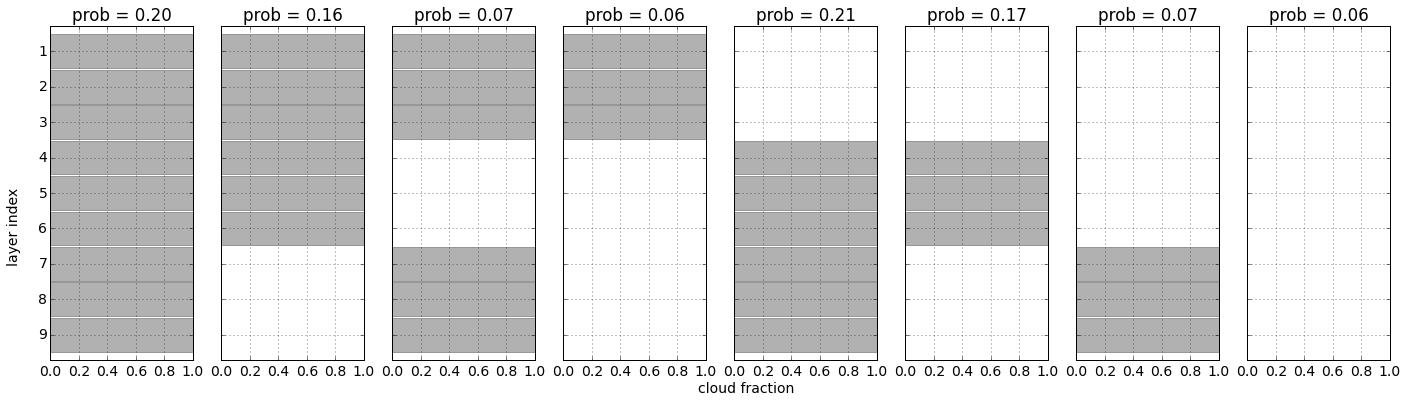

In [41]:
fig = maxrand_plot_maxcol(model = column_model)
fig = maxrand_plot_subcol_prob(model = column_model)

https://datasciencelab.wordpress.com/2013/12/21/beautiful-plots-with-pandas-and-matplotlib/